### [Intro to Haystack Pipelines ](https://www.youtube.com/watch?v=SxAwyeCkguc&t=313s)

In [1]:
from haystack import Pipeline

pipeline = Pipeline()

In [2]:
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()

In [3]:
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter

pipeline.add_component("embedder", SentenceTransformersDocumentEmbedder())
pipeline.add_component("writer", DocumentWriter(document_store))

pipeline.connect("embedder", "writer")

🚅 Components
  - embedder: SentenceTransformersDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - embedder.documents -> writer.documents (List[Document])

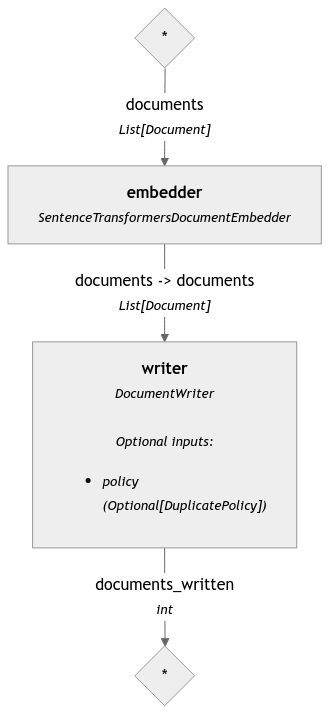

In [4]:
pipeline.show()

In [5]:
from haystack.dataclasses import Document

pipeline.run({"embedder":{"documents":[Document(content="Tuana is from Istambul"),
                                       Document(content="Silvano is from turin"),
                                       Document(content="Julian is from Berlin")]}})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'writer': {'documents_written': 3}}

In [6]:
document_store.filter_documents()

[Document(id=a7a5d159b93a3f71d161f8623dddcec56a70c2b04ba6978e166772d7f610a5fb, content: 'Tuana is from Istambul', embedding: vector of size 768),
 Document(id=f9a073eb7054e4177751abc0c9cc7f9081e9add46ab0f63f90beaf32fcfed406, content: 'Silvano is from turin', embedding: vector of size 768),
 Document(id=ffd7c423bfd6b192df4131b0163168943a4767d2c5240c650c54e57a00f4222d, content: 'Julian is from Berlin', embedding: vector of size 768)]

### RAG pipeline

In [7]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.builders import  PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.utils import Secret


embedder = SentenceTransformersTextEmbedder()

retriver = InMemoryEmbeddingRetriever(document_store=document_store)

template = """
Given the following information, answer the question.

Context: 
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{ query }}?
"""

promt_builder = PromptBuilder(template=template)

generator = OpenAIGenerator(
        api_key=Secret.from_env_var("OPENAI_API_KEY"),  # Clave API desde variable de entorno
        model="gpt-4o-mini-2024-07-18"  # Modelo específico
    )

In [8]:
rag_pipeline = Pipeline()
rag_pipeline.add_component("embedder", embedder)
rag_pipeline.add_component("retriever", retriver)
rag_pipeline.add_component("prompt_builder", promt_builder)
rag_pipeline.add_component("generator", generator)

rag_pipeline.connect("embedder", "retriever")
rag_pipeline.connect("retriever.documents", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "generator")



🚅 Components
  - embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)

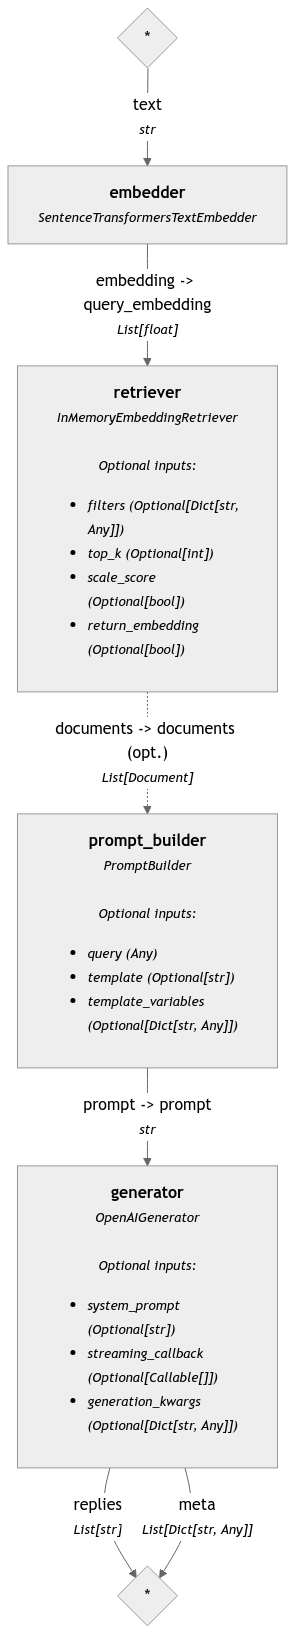

In [9]:
rag_pipeline.show()

In [11]:
question = "Where is Tuana from?"

rag_pipeline.run({"embedder": {"text": question},
                  "prompt_builder": {"query": question}})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'generator': {'replies': ['Tuana is from Istanbul.'],
  'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 6,
     'prompt_tokens': 50,
     'total_tokens': 56,
     'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0),
     'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}]}}